# Configs

In [1]:
!pip install pydicom -q
!pip install torch==2.1 torchvision==0.16 -q
!pip install -qU pycocotools
!pip install -qU wandb

In [2]:
for name in list(globals()):
    if not name.startswith("_"):  # Avoid deleting built-in and special variables
        del globals()[name]

In [3]:
CONDITION = 'RightSubarticularStenosis'

In [4]:
# !nvidia-smi

## Load libraries

In [5]:
import os
import time
from datetime import datetime
import numpy as np
import collections
import random
import torch

from matplotlib import animation, rc
import pandas as pd

import matplotlib.pyplot as plt

## Reproducibility

In [6]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Directories

In [7]:
PROJECT_DIR = '/home/jupyter'
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
SRC_DIR = os.path.join(PROJECT_DIR, 'src')
CROP_DIR = os.path.join(DATA_DIR, 'train_crops', '02_train_disc_detection', CONDITION)
os.makedirs(CROP_DIR, exist_ok=True)
MODEL_DIR = os.path.join(PROJECT_DIR, 'models', '04_train_severity_classification', CONDITION)
os.makedirs(MODEL_DIR, exist_ok=True)

## For fine-tune on trained spinal-canal-stenosis model
REFERENCE_MODEL_DIR = os.path.join(PROJECT_DIR, 'models', '04_train_severity_classification', 'LeftSubarticularStenosis')
REFERENCE_MODEL_BEST_EPOCH = 2

## Functions

In [8]:
with open(os.path.join(SRC_DIR, 'pipeline_severity_classification.py')) as file:
    exec(file.read())

## Hyperparameters

In [9]:
CONFIG = dict(
    num_epochs=6,
    batch_size=50,
    lr=0.00001,
    lr_step_size=3,
    lr_gamma=0.1
)

## Metadata

In [10]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'train.csv'))
val_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'val.csv'))

<div style="font-size: 16px;">
    Add the cropped image path to metadata:
</div>

In [11]:
LABELS_DICT = {
    1: "L1_L2",
    2: "L2_L3",
    3: "L3_L4",
    4: "L4_L5",
    5: "L5_S1"
}

In [12]:
# def get_cropped_image_path(row):
#     return f"{CROP_DIR}/{row['study_id']}/{row['series_id']}/{LABELS_DICT[row['level_code']]}/{row['instance_number']}.pt"

# train_df['cropped_image_path'] = [get_cropped_image_path(row) for i, row in train_df.iterrows()]
# val_df['cropped_image_path']   = [get_cropped_image_path(row) for i, row in val_df.iterrows()]

## Some example cropped images

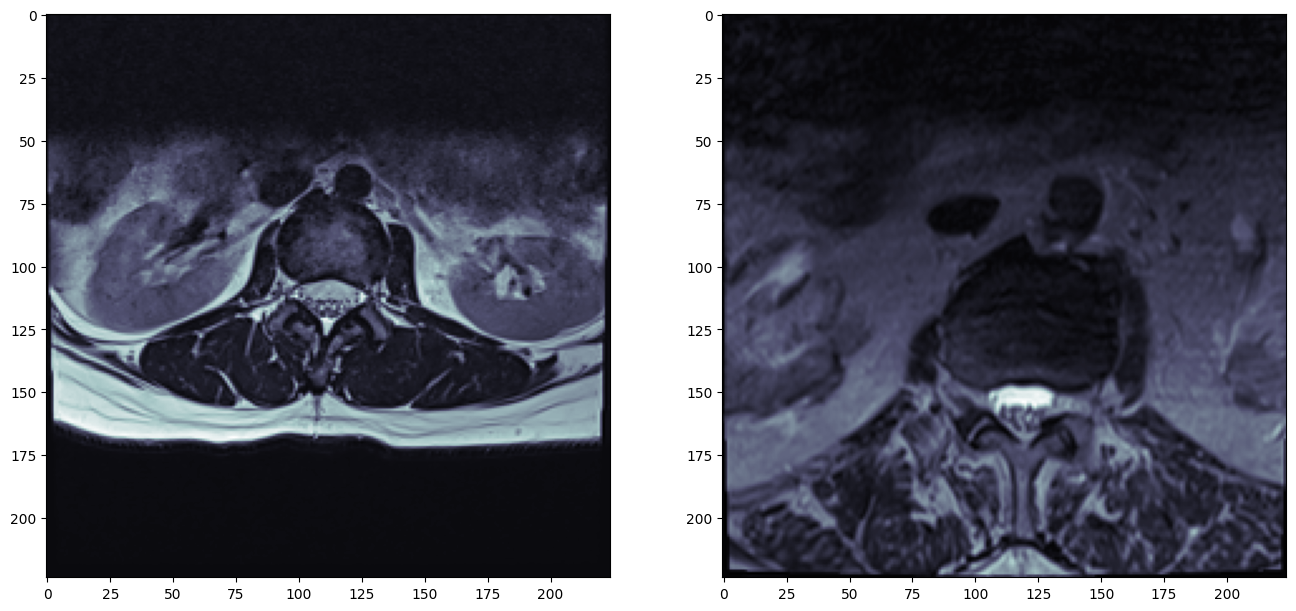

In [13]:
tmp_ds = RSNAUncroppedImageDataset(train_df)
tmp_dl = torch.utils.data.DataLoader(
  tmp_ds,
  batch_size=1,
  shuffle=False
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
for i, (img, label) in enumerate(tmp_dl):
    if i == 2: break
    y = img[0][0].numpy()
    ax[i].imshow(y, cmap=plt.cm.bone)
del tmp_ds, tmp_dl

# Training

## Load Model

In [14]:
referece_model_path = os.path.join(f"{REFERENCE_MODEL_DIR}/epoch_{REFERENCE_MODEL_BEST_EPOCH}/model_dict.pt")
model = load_model_severity_classification(state_dict=torch.load(referece_model_path))

In [15]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in the model: {count_trainable_parameters(model)}")

Number of trainable parameters in the model: 27584877


## Test forward

In [16]:
# Create dataset and dataloader
dataset = RSNAUncroppedImageDataset(train_df)
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=1,
  shuffle=True
)

In [17]:
# Get first input from dataloader
images, labels = next(iter(data_loader))

# Inference
model.to('cpu')
model.eval()
with torch.inference_mode():
    predictions = model(images)

In [18]:
print(f"Predicted values for 3 classes in one sample: {predictions.squeeze().tolist()}")

Predicted values for 3 classes in one sample: [4.4993367195129395, 0.5980314612388611, -4.878913402557373]


## Train and validate

In [19]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()
# !nvidia-smi

In [20]:
model_pipeline(config=CONFIG, model=model, model_dir=MODEL_DIR, train_df=train_df, val_df=val_df, device=device, 
               datasetter=RSNAUncroppedImageDataset, limit=None)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ning-shen (ning-shen-university-of-british-columbia). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.6
wandb: Run data is saved locally in /home/jupyter/notebooks/wandb/run-20241113_032547-ohcccdx7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run vague-cloud-47
wandb: ⭐️ View project at https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo
wandb: 🚀 View run at https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo/runs/ohcccdx7
  0%|          | 0/6 [00:00<?, ?it/s]

Loss after 00950 examples: 0.596
Batch 20 Metrics:
  Accuracy: 71.89%
  Class 0: Precision: 0.9215, Recall: 0.7826, F1-score: 0.8464
  Class 1: Precision: 0.3625, Recall: 0.5088, F1-score: 0.4234
  Class 2: Precision: 0.4516, Recall: 0.6292, F1-score: 0.5258
Loss after 01950 examples: 0.611
Batch 40 Metrics:
  Accuracy: 73.50%
  Class 0: Precision: 0.9285, Recall: 0.8000, F1-score: 0.8595
  Class 1: Precision: 0.3975, Recall: 0.5191, F1-score: 0.4502
  Class 2: Precision: 0.4242, Recall: 0.6437, F1-score: 0.5114
Loss after 02950 examples: 0.699
Batch 60 Metrics:
  Accuracy: 72.10%
  Class 0: Precision: 0.9151, Recall: 0.8008, F1-score: 0.8542
  Class 1: Precision: 0.3814, Recall: 0.4688, F1-score: 0.4206
  Class 2: Precision: 0.4286, Recall: 0.6316, F1-score: 0.5106


 17%|█▋        | 1/6 [06:19<31:35, 379.19s/it]

Validation Metrics:
  Loss: 0.8046
  Accuracy: 72.47%
  Class 0: Precision: 0.8957, Recall: 0.8249, F1-score: 0.8588
  Class 1: Precision: 0.4516, Recall: 0.5045, F1-score: 0.4766
  Class 2: Precision: 0.4247, Recall: 0.5345, F1-score: 0.4733
Loss after 03949 examples: 0.624
Batch 20 Metrics:
  Accuracy: 75.37%
  Class 0: Precision: 0.9164, Recall: 0.8265, F1-score: 0.8692
  Class 1: Precision: 0.4558, Recall: 0.5309, F1-score: 0.4905
  Class 2: Precision: 0.5159, Recall: 0.6989, F1-score: 0.5936
Loss after 04949 examples: 0.767
Batch 40 Metrics:
  Accuracy: 75.80%
  Class 0: Precision: 0.9270, Recall: 0.8223, F1-score: 0.8715
  Class 1: Precision: 0.4182, Recall: 0.5169, F1-score: 0.4623
  Class 2: Precision: 0.5074, Recall: 0.7188, F1-score: 0.5948
Loss after 05949 examples: 0.725
Batch 60 Metrics:
  Accuracy: 75.10%
  Class 0: Precision: 0.9027, Recall: 0.8458, F1-score: 0.8734
  Class 1: Precision: 0.3653, Recall: 0.3506, F1-score: 0.3578
  Class 2: Precision: 0.4403, Recall: 0.737

 33%|███▎      | 2/6 [09:14<17:18, 259.54s/it]

Validation Metrics:
  Loss: 0.7866
  Accuracy: 74.57%
  Class 0: Precision: 0.8886, Recall: 0.8559, F1-score: 0.8719
  Class 1: Precision: 0.4909, Recall: 0.4865, F1-score: 0.4887
  Class 2: Precision: 0.4583, Recall: 0.5690, F1-score: 0.5077
Loss after 06948 examples: 0.533
Batch 20 Metrics:
  Accuracy: 75.26%
  Class 0: Precision: 0.9215, Recall: 0.8273, F1-score: 0.8719
  Class 1: Precision: 0.4203, Recall: 0.4888, F1-score: 0.4519
  Class 2: Precision: 0.4454, Recall: 0.6883, F1-score: 0.5408
Loss after 07948 examples: 0.524
Batch 40 Metrics:
  Accuracy: 78.40%
  Class 0: Precision: 0.9180, Recall: 0.8567, F1-score: 0.8863
  Class 1: Precision: 0.5054, Recall: 0.4895, F1-score: 0.4973
  Class 2: Precision: 0.5172, Recall: 0.8242, F1-score: 0.6356
Loss after 08948 examples: 0.552
Batch 60 Metrics:
  Accuracy: 79.20%
  Class 0: Precision: 0.9230, Recall: 0.8641, F1-score: 0.8926
  Class 1: Precision: 0.4503, Recall: 0.4914, F1-score: 0.4699
  Class 2: Precision: 0.6194, Recall: 0.798

 50%|█████     | 3/6 [10:59<09:26, 188.97s/it]

Validation Metrics:
  Loss: 0.8026
  Accuracy: 74.38%
  Class 0: Precision: 0.8932, Recall: 0.8503, F1-score: 0.8712
  Class 1: Precision: 0.4860, Recall: 0.4685, F1-score: 0.4771
  Class 2: Precision: 0.4557, Recall: 0.6207, F1-score: 0.5255
Loss after 09947 examples: 0.522
Batch 20 Metrics:
  Accuracy: 78.21%
  Class 0: Precision: 0.9188, Recall: 0.8399, F1-score: 0.8776
  Class 1: Precision: 0.4670, Recall: 0.5227, F1-score: 0.4933
  Class 2: Precision: 0.5920, Recall: 0.8506, F1-score: 0.6981
Loss after 10947 examples: 0.370
Batch 40 Metrics:
  Accuracy: 79.20%
  Class 0: Precision: 0.9309, Recall: 0.8552, F1-score: 0.8914
  Class 1: Precision: 0.5126, Recall: 0.5340, F1-score: 0.5231
  Class 2: Precision: 0.5185, Recall: 0.8333, F1-score: 0.6393
Loss after 11947 examples: 0.436
Batch 60 Metrics:
  Accuracy: 80.20%
  Class 0: Precision: 0.9331, Recall: 0.8638, F1-score: 0.8971
  Class 1: Precision: 0.4731, Recall: 0.5146, F1-score: 0.4930
  Class 2: Precision: 0.6099, Recall: 0.843

 67%|██████▋   | 4/6 [12:44<05:11, 155.67s/it]

Validation Metrics:
  Loss: 0.8194
  Accuracy: 75.33%
  Class 0: Precision: 0.8895, Recall: 0.8644, F1-score: 0.8768
  Class 1: Precision: 0.5094, Recall: 0.4865, F1-score: 0.4977
  Class 2: Precision: 0.4658, Recall: 0.5862, F1-score: 0.5191
Loss after 12946 examples: 0.602
Batch 20 Metrics:
  Accuracy: 78.84%
  Class 0: Precision: 0.9224, Recall: 0.8510, F1-score: 0.8852
  Class 1: Precision: 0.4531, Recall: 0.5210, F1-score: 0.4847
  Class 2: Precision: 0.5965, Recall: 0.8000, F1-score: 0.6834
Loss after 13946 examples: 0.533
Batch 40 Metrics:
  Accuracy: 80.50%
  Class 0: Precision: 0.9319, Recall: 0.8808, F1-score: 0.9056
  Class 1: Precision: 0.5000, Recall: 0.4862, F1-score: 0.4930
  Class 2: Precision: 0.5522, Recall: 0.8315, F1-score: 0.6637
Loss after 14946 examples: 0.592
Batch 60 Metrics:
  Accuracy: 80.90%
  Class 0: Precision: 0.9103, Recall: 0.8780, F1-score: 0.8939
  Class 1: Precision: 0.5532, Recall: 0.5333, F1-score: 0.5431
  Class 2: Precision: 0.6515, Recall: 0.860

 83%|████████▎ | 5/6 [14:28<02:16, 136.92s/it]

Validation Metrics:
  Loss: 0.8413
  Accuracy: 75.53%
  Class 0: Precision: 0.8870, Recall: 0.8644, F1-score: 0.8755
  Class 1: Precision: 0.5189, Recall: 0.4955, F1-score: 0.5069
  Class 2: Precision: 0.4722, Recall: 0.5862, F1-score: 0.5231
Loss after 15945 examples: 0.364
Batch 20 Metrics:
  Accuracy: 82.11%
  Class 0: Precision: 0.9356, Recall: 0.8815, F1-score: 0.9077
  Class 1: Precision: 0.5368, Recall: 0.5763, F1-score: 0.5559
  Class 2: Precision: 0.6296, Recall: 0.8395, F1-score: 0.7196
Loss after 16945 examples: 0.623
Batch 40 Metrics:
  Accuracy: 79.00%
  Class 0: Precision: 0.9188, Recall: 0.8532, F1-score: 0.8848
  Class 1: Precision: 0.4632, Recall: 0.5000, F1-score: 0.4809
  Class 2: Precision: 0.6015, Recall: 0.8421, F1-score: 0.7018
Loss after 17945 examples: 0.477
Batch 60 Metrics:
  Accuracy: 79.00%
  Class 0: Precision: 0.9227, Recall: 0.8541, F1-score: 0.8871
  Class 1: Precision: 0.5000, Recall: 0.5263, F1-score: 0.5128
  Class 2: Precision: 0.5786, Recall: 0.835

100%|██████████| 6/6 [16:12<00:00, 162.03s/it]

Validation Metrics:
  Loss: 0.8307
  Accuracy: 75.14%
  Class 0: Precision: 0.8863, Recall: 0.8588, F1-score: 0.8723
  Class 1: Precision: 0.5093, Recall: 0.4955, F1-score: 0.5023
  Class 2: Precision: 0.4722, Recall: 0.5862, F1-score: 0.5231



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      accuracy ▁▂▁▃▄▃▃▅▆▅▆▇▆▇▇█▆▆
wandb:         epoch ▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
wandb:          loss ▅▅▇▆█▇▄▄▄▄▁▂▅▄▅▁▆▃
wandb: test_accuracy ▁▆▅██▇
wandb:     test_loss ▃▁▃▅█▇
wandb: 
wandb: Run summary:
wandb:      accuracy 0.79
wandb:         epoch 5
wandb:          loss 0.47672
wandb: test_accuracy 0.75143
wandb:     test_loss 0.83072
wandb: 
wandb: 🚀 View run vague-cloud-47 at: https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo/runs/ohcccdx7
wandb: ⭐️ View project at: https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20241113_032547-ohcccdx7/logs


<div style="font-size: 16px;"><strong>
    CONCLUSION: We pick the model generated by the 2nd epoch (i.e., epoch 1) because it has the lowest validation loss and highest validation accuracy!
</strong></div>